In [92]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import glob 
import os

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, precision_score, precision_recall_curve, f1_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

player_df = pd.read_json("data/1980-2018-per100-labeled.json")
player_df19 = pd.read_json("data/2019-per-100.json")
combined_df = pd.read_json("data/combined-player-team-stats.json")
combined_df19 = pd.read_json("data/2019-combined.json")

In [93]:
combined_df.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA_x', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA_x', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST_x', 'STL_x', 'BLK_x', 'TOV_x', 'PF_x', 'PTS_x',
       'ORtg', 'DRtg', 'Year', 'MVP', 'player_id', 'GP', 'WINS', 'LOSSES',
       'WIN_PCT', 'CONF_RANK', 'DIV_RANK', 'PO_WINS', 'PO_LOSSES',
       'CONF_COUNT', 'DIV_COUNT', 'NBA_FINALS_APPEARANCE', 'FGM', 'FGA_y',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA_y', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST_y', 'PF_y', 'STL_y', 'TOV_y', 'BLK_y', 'PTS_y',
       'PTS_RANK'],
      dtype='object')

In [94]:
y_features = "MVP"
#x_features = ["Player","Year","Tm","MP","FG","FGA","3P","3PA","2P","2PA","FT","FTA","ORB","DRB","AST","STL","BLK","TOV","PF","PTS"]
x_features = ['Player','Year', 'Tm', 'MP', 'FG', 'FGA_x',
       '3P', '3PA', '2P', '2PA', 'FT', 'FTA_x', 'ORB',
       'DRB', 'TRB', 'AST_x', 'STL_x', 'BLK_x', 'TOV_x', 'PF_x', 'PTS_x',
       'ORtg', 'DRtg','WIN_PCT', 'CONF_RANK']
#x_all = player_df[x_features]
x_all = combined_df[x_features]
#y_all = player_df[y_features]
y_all = combined_df[y_features]
# Drop the columns containing text data, leaving only numerical data
drop_txt = lambda x: x.drop(columns=["Player", "Year", "Tm"])
x_all_num = drop_txt(x_all)

In [95]:
x_old = x_all.loc[x_all.Year > 1980]
y_old = y_all.loc[x_all.Year > 1980]
x_19 = combined_df19[x_features]
x_19 = x_19[x_19['MP'] > 800]
x_train, x_test, y_train, y_test = train_test_split(x_old, y_old, test_size=0.3)

In [96]:
x_train_num = drop_txt(x_train)
x_test_num = drop_txt(x_test) 
x_old_num = drop_txt(x_old) 
x_new_num = drop_txt(x_19)
x_train_num = x_old_num
y_train = y_old

In [97]:
scale_pipe = lambda x: Pipeline([("scaler", StandardScaler()), x])
calibrate = lambda x: CalibratedClassifierCV(x, method='isotonic', cv=5)

In [98]:
xgb_calib = calibrate(XGBClassifier(learning_rate = 0.1, n_jobs=2, n_estimators=100))
xgb_uncalib = XGBClassifier(learning_rate = 0.1, n_jobs=2, n_estimators=100)
xgb_clf = scale_pipe(("xgb", xgb_calib))
xgb_clf_u = scale_pipe(("xgb", xgb_uncalib))
xgb_clf.fit(x_train_num, y_train)
xgb_clf_u.fit(x_train_num, y_train)
#precf_gb, recf_gb, thrf_gb = precision_recall_curve(y_test, xgb_clf.predict_proba(x_test_num).transpose()[1], pos_label=1)
#plt.plot(recf_gb, precf_gb)
xgb_feat = xgb_clf_u.named_steps['xgb'].feature_importances_

In [99]:
xgb_pred_prob = xgb_clf.predict_proba(x_new_num).transpose()[1]
xgb_pred_indices = np.where(xgb_pred_prob > 0.1)

In [100]:
rf_calib = calibrate(RandomForestClassifier(n_jobs=2, n_estimators=100, max_features="auto"))
rf_uncalib = RandomForestClassifier(n_jobs=2,n_estimators=100, max_features="auto")
rf_clf = scale_pipe(("forest", rf_calib))
rf_clf_u = scale_pipe(("rf", rf_uncalib))
rf_clf.fit(x_train_num, y_train)
rf_clf_u.fit(x_old_num, y_old)
rf_pred_prob = rf_clf.predict_proba(x_new_num).transpose()[1]
#precf_rf,recf_rf,thrf_rf = precision_recall_curve(y_test, rf_clf.predict_proba(x_test_num).transpose()[1], pos_label=1)
#plt.plot(recf_rf, precf_rf)
feature_import = rf_clf_u.named_steps['rf'].feature_importances_

In [112]:
mlp = calibrate(MLPClassifier(solver='lbfgs', alpha = 1e-5,
                    hidden_layer_sizes=(10, 10)))
mlp_clf = scale_pipe(("mlp", mlp))
mlp_clf.fit(x_old_num, y_old)
mlp_pred_prob = mlp_clf.predict_proba(x_new_num).transpose()[1]

In [113]:
interp = 0.5
stacked_prob = np.mean([xgb_pred_prob, rf_pred_prob, mlp_pred_prob], axis=0)
stacked_indices = np.where(stacked_prob > 0.03)
stacked_prob[stacked_indices]
x_19['Probability'] = stacked_prob
mvp_candiates = x_19.iloc[stacked_indices]
#x_19[x_19['MP'] > 900].sort_values(by='Probability',ascending=False)
mvp_candidates = x_19.loc[x_19.Probability > 0.1]
mvp_candidates.to_json("data/mvp-prediction-2019.json")

In [114]:
mvp_summary = mvp_candiates.sort_values(by='Probability',ascending=False)[['Player','Probability']]
mvp_summary

,Player,Probability
143,Giannis Antetokounmpo,0.385033
88,James Harden,0.310212
155,Stephen Curry,0.247355
156,Kevin Durant,0.127396
181,Nikola Jokic,0.109183
271,Kawhi Leonard,0.106149
72,Joel Embiid,0.096825
9,Russell Westbrook,0.042891
289,Nikola Vucevic,0.033862


In [104]:
x_19[x_19['MP'] > 900].sort_values(by='Probability',ascending=False)

,Player,Year,Tm,MP,FG,FGA_x,3P,3PA,2P,2PA,FT,FTA_x,ORB,DRB,TRB,AST_x,STL_x,BLK_x,TOV_x,PF_x,PTS_x,ORtg,DRtg,WIN_PCT,CONF_RANK,Probability
143,Giannis Antetokounmpo,2019,MIL,1495,13.9,24.1,0.7,3.3,13.2,20.8,9.1,13.0,3.3,14.6,17.9,8.2,1.9,2.0,5.6,4.8,37.5,118,99,0.729,1,0.323159
88,James Harden,2019,HOU,1721,14.0,31.8,6.5,17.5,7.5,14.3,13.7,15.8,1.3,7.4,8.7,10.8,2.7,1.0,7.3,4.5,48.2,118,111,0.592,5,0.315568
155,Stephen Curry,2019,GSW,1308,13.5,27.6,7.2,16.1,6.4,11.5,6.4,6.9,1.0,6.1,7.1,7.6,1.6,0.5,3.9,3.5,40.7,124,112,0.714,1,0.250309
156,Kevin Durant,2019,GSW,1745,13.0,25.5,2.6,6.8,10.4,18.7,8.9,9.9,0.6,9.2,9.8,7.9,1.1,1.6,4.4,2.6,37.4,119,110,0.714,1,0.122339
271,Kawhi Leonard,2019,TOR,1332,13.3,26.5,2.5,6.8,10.8,19.7,9.2,10.7,1.9,9.1,11.0,4.4,2.6,0.7,2.9,2.1,38.4,122,106,0.712,2,0.099819
181,Nikola Jokic,2019,DEN,1467,12.0,23.8,1.9,5.8,10.2,18.0,6.0,7.1,4.5,12.1,16.6,12.3,2.1,1.1,4.9,4.5,31.9,121,105,0.688,2,0.067181
72,Joel Embiid,2019,PHI,1539,12.8,26.2,1.7,5.5,11.1,20.7,11.2,13.9,3.4,15.4,18.9,5.0,0.8,2.8,4.9,4.7,38.5,114,104,0.640,4,0.046879
289,Nikola Vucevic,2019,ORL,1529,13.6,26.3,1.8,4.9,11.8,21.4,3.5,4.5,4.3,14.8,19.1,6.0,1.6,1.8,3.2,3.2,32.6,114,105,0.400,11,0.033862
96,Anthony Davis,2019,NOP,1519,13.3,26.2,1.2,3.8,12.1,22.4,9.4,11.6,4.3,12.6,16.9,5.5,2.2,3.3,2.5,3.3,37.3,124,106,0.440,13,0.021515
3,Paul George,2019,OKC,1727,11.8,26.4,4.7,11.6,7.1,14.8,7.0,8.4,2.0,8.5,10.5,5.2,3.0,0.6,3.4,3.6,35.2,117,103,0.633,3,0.014581


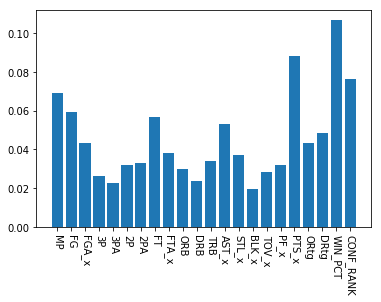

<BarContainer object of 22 artists>

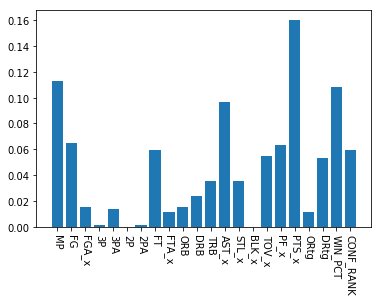

In [105]:
plt.xticks(rotation=-90)
plt.bar(x_features[3:], feature_import)
plt.show()
plt.xticks(rotation=-90)
plt.bar(x_features[3:], xgb_feat)

In [106]:
#import umap
#embedding = umap.UMAP(n_neighbors=200, min_dist = 0.5).fit_transform(x_old_num)

In [107]:
#['Player','Year', 'Tm', 'MP', 'FG', 'FGA_x',
#       '3P', '3PA', '2P', '2PA', 'FT', 'FTA_x', 'ORB',
#       'DRB', 'TRB', 'AST_x', 'STL_x', 'BLK_x', 'TOV_x', 'PF_x', 'PTS_x',
#       'ORtg', 'DRtg','WIN_PCT', 'CONF_RANK']
#plt.style.use('dark_background')
#plt.figure(figsize=(10,7))
#plt.scatter(embedding[:, 0], embedding[:, 1], c=x_old_num['TRB'], s=0.01*(x_old_num['MP']-300), cmap="plasma")

In [108]:
x_old_num['MP'].min()

315